In [1]:
import open3d as o3d
import numpy as np
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import math
from functools import reduce

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
pcd = o3d.io.read_point_cloud("point_clouds/heap_example.ply")
# pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()

In [7]:
o3d.visualization.draw_geometries([pcd])

In [8]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=15,
                                                    std_ratio=1.1)
pcd_clean = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([pcd_clean])

In [36]:
pts = np.asarray(pcd.points)
pts[10]

array([ 0.86117928, -1.55142943,  3.60699558])

In [9]:
voxel_pcd = pcd_clean.voxel_down_sample(voxel_size=5e-3)
voxel_pcd

PointCloud with 59743 points.

In [10]:
voxel_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.0104,max_nn=15))
print('run Poisson surface reconstruction')
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(voxel_pcd, depth=10, width=0, scale=1.1, linear_fit=True)
o3d.visualization.draw_geometries([mesh])

run Poisson surface reconstruction
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [11]:
xyz = np.asarray(voxel_pcd.points)
xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])
tri = Delaunay(np.array(xy_catalog))

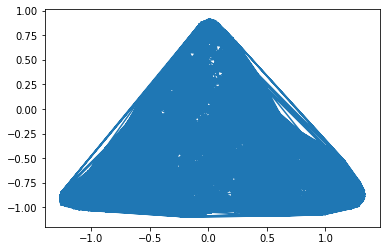

In [12]:
xy_catalog = np.array(xy_catalog)
plt.triplot(xy_catalog[:,0], xy_catalog[:,1], tri.simplices)

In [13]:
surface = o3d.geometry.TriangleMesh()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
surface.paint_uniform_color([0, 0, 1.0])
o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)

In [14]:
def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

In [15]:
def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

In [16]:
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)
print(f"The volume of the object is: {round(volume, 4)} m3")

The volume of the object is: 1.037 m3
